## Get the light curve

```collections = 'LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865'```

```skymap = 'ops_rehersal_prep_2k_v1'```

1. Select a tract and patch which has a good deepcoadd image in g, r, i bands
2. From this patch, pick an (ra, dec) which has the highest g band flux from the ObjectTable (just so that we know it actually got observed) 
4. Ask James’ function what truth parquet files overlap this (ra, dec)
5. For each of these truth tables
    - Select variable objects and 17 < magnorm < 19
    - cross match the truth file with the ObjectTable to find objects within 2 arcsec
    - We will ge the light curve for this closes match object. Get the (ra, dec), magnorm, mag_amplitude, period, and phase for this object
3. Ask the skymap what (tract, patch) the (ra, dec) lies in
4. Find the closest match for this (ra, dec) from diaObjectTable_tract. Get the diaObjectId
5. For this diaObjectId, get the flux from diaSourceTable_tract
6. Convert nJy to mag. Get the error based on nJy flux
   
   ```g_mag = (scienceFlux*u.nJy).to(u.ABmag).value```
   
   ```g_mag_err = 1.09*'scienceFluxErr/'scienceFlux'```

### Equation to calculate the true magnitude from the pipeline mjd

```truth_magnitude_at_time_of_visit = magnorm + mag_amplitude*sin(2.*pi*(mjd - mjd0)/period + phase)```

```where mjd0 = 60400 and mjd = mjdMidpointTai```  

<font color='red'>1. Which band does this equation give the flux for?</font> 

<font color='red'>2. Why is there an offset between true and pipeline flux?<font>

<font color='red'>3. Some patches which have deepCoadd images do not have ObjecTable e.g. patch 208<font>

In [1]:
# Standard imports:
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.units as u

import glob as glob
import os

from astropy.coordinates import Angle
import lsst.geom

In [2]:
afwDisplay.setDefaultBackend('matplotlib')
from lsst.rsp import get_tap_service
service = get_tap_service("tap")

In [3]:
# A funuction to determine the filename of a truthtable covering a DIA detecor image.
def GetTruthFiles(RA, Dec):
    '''
    Given a set of coordinates, determine the filename of the pointsource parquet
    truth table that covers that region. This is needed because the parquet files
    are named according to the htm7 nside=32 region that they cover, so the index
    of the htm7 segment is needed to identify the file.

    Note
    ----
    This calculates the mean coordinate of the catalogue and uses that to
    determine the htm7 segment.

    Inputs
    ------
    RA: Pandas series containing the Right Ascention of sources in degrees.
    Dec: Pandas series containing the Deckination of sources in degrees.

    Outputs
    -------
    truthFiles: List of filenames of the truth table parquet files that cover the
                region of interest.
    
    '''
    truthFiles = []

    mean_ra = np.deg2rad(np.mean(RA.value))
    mean_de = np.deg2rad(90. - np.mean(Dec.value))
    coordVec = hp.ang2vec(mean_de, mean_ra)
    ipix_discs = hp.query_disc(nside=32, vec=coordVec, radius=np.radians(2))

    for ipix_disc in ipix_discs:
        filename = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/pointsource_{}.parquet'.format(ipix_disc)
        if os.path.exists(filename):
            truthFiles.append(filename)        
    return truthFiles

In [21]:
# Butler setup and skyMap retrieval:
collections = 'LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865'
butler = dafButler.Butler('/repo/embargo', collections=collections)
registry = butler.registry
skyMap = butler.get('skyMap', dataId={'skymap':'ops_rehersal_prep_2k_v1'})

In [5]:
# # select a tract and patch
# for i, dt in enumerate(registry.queryDatasets(datasetType='goodSeeingCoadd', collections=collections)):
#     # print(dt.dataId['tract'])
#     if 100 < i < 150:
#         print(dt.dataId)

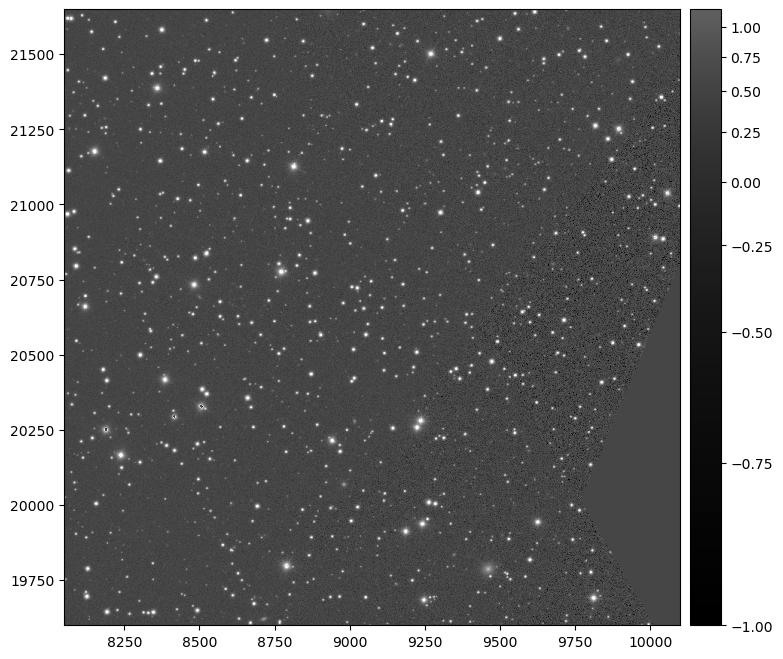

In [6]:
tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': 2494, 'patch': 209}
tract_im = butler.get('deepCoadd', dataId=tract_dataid)

fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(tract_im.image)
plt.gca().axis('on')
plt.show()
plt.close()

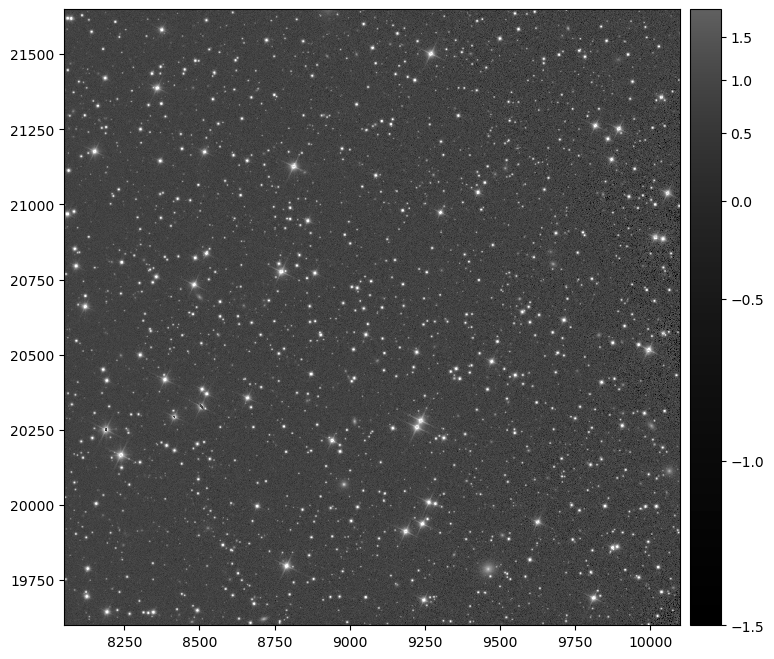

In [7]:
tract_dataid = {'band': 'i', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': 2494, 'patch': 209}
tract_im = butler.get('deepCoadd', dataId=tract_dataid)

fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(tract_im.image)
plt.gca().axis('on')
plt.show()
plt.close()

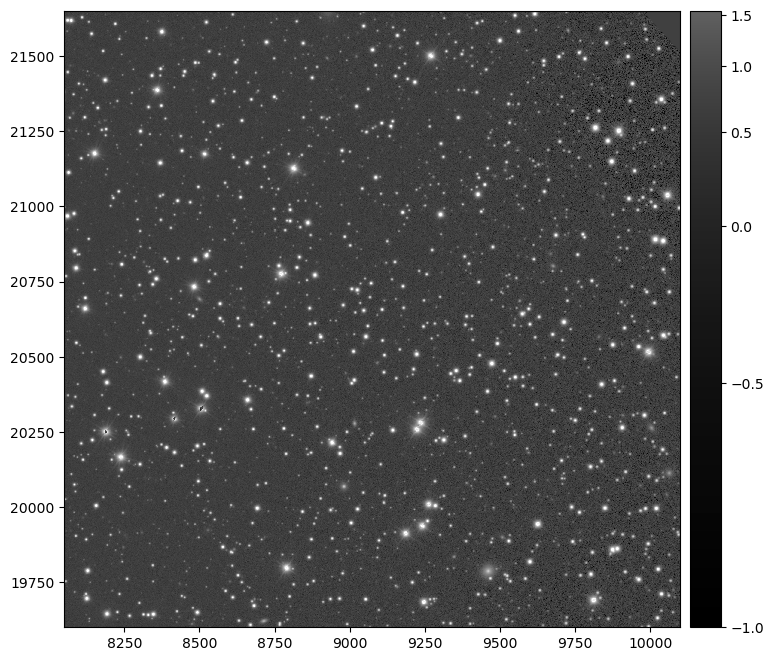

In [8]:
tract_dataid = {'band': 'r', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': 2494, 'patch': 209}
tract_im = butler.get('deepCoadd', dataId=tract_dataid)

fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(tract_im.image)
plt.gca().axis('on')
plt.show()
plt.close()

### Select ra, dec from object table

In [9]:
tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': 2494, 'patch': 209}
obj_table = butler.get('objectTable', dataId=tract_dataid)
obj_table = obj_table.reset_index()

# select a bright object from g band 
obj_table = obj_table[obj_table['refBand'] == 'g']
obj_table = obj_table.sort_values('g_psfFlux', ascending=False) 

In [10]:
obj_table['g_psfFlux'][0:5]

25      1.410243e+06
2838    1.410193e+06
2348    1.352886e+06
8056    1.352870e+06
481     1.336846e+06
Name: g_psfFlux, dtype: float64

In [11]:
# obj_table.columns.to_list()

In [12]:
obj_ra = obj_table['coord_ra'].values[0]
obj_dec = obj_table['coord_dec'].values[0]

### Get truth files for this ra, dec

In [13]:
def find_match_truth_objtable(truthfile, obj_table):
    # print(truthFile)
    truthTable = pd.read_parquet(truthFile)
    
    # select variable stars
    truthTable = truthTable[truthTable['is_variable'] == True]
    truthTable = truthTable.sort_values('magnorm', ascending=True)
    truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]
    
    # cross match with the object table
    trueCoords = SkyCoord(ra=truthTable['ra'].values*u.degree, dec=truthTable['dec'].values*u.degree)
    objCoords = SkyCoord(ra=obj_table['coord_ra'].values*u.degree, dec=obj_table['coord_dec'].values*u.degree)

    idx, d2d, d3d = objCoords.match_to_catalog_sky(trueCoords) # idx is closest index in trueCoords

    # print('length of objCoords table: ',len(objCoords))
    # print('length of indices: ',len(idx))

    # select closest matche within 2"
    d2d_inx = np.where(d2d < 2*u.arcsec)
    idx = idx[d2d_inx]
    d2d = d2d[d2d_inx]

    # print(idx)
    return truthFile, idx

In [14]:
for truthFile in GetTruthFiles(obj_ra*u.degree, obj_dec*u.degree):
    truthfile, idx = find_match_truth_objtable(truthFile, obj_table)
    if len(idx) != 0:
        truthfile_match = truthfile
        idx_match = idx[0]

In [15]:
print(truthfile_match)
print(idx_match)

/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/pointsource_10750.parquet
702


In [16]:
# select variable star from the truth table where there is a match for the (ra,dec) from the object table

truthTable = pd.read_parquet(str(truthfile_match))
    
truthTable = truthTable[truthTable['is_variable'] == True]
truthTable = truthTable.sort_values('magnorm', ascending=True)
truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]

In [17]:
truthTable.columns.to_list()

['object_type',
 'id',
 'ra',
 'dec',
 'host_galaxy_id',
 'magnorm',
 'sed_filepath',
 'MW_rv',
 'MW_av',
 'mura',
 'mudec',
 'radial_velocity',
 'parallax',
 'variability_model',
 'salt2_params',
 'is_variable',
 'period',
 'mag_amplitude',
 'phase']

In [18]:
truthTable[idx_match:idx_match+1]

,object_type,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,variability_model,salt2_params,is_variable,period,mag_amplitude,phase
123470,star,40906364988,279.190005,-47.953509,0,17.291074,starSED/kurucz/km10_4750.fits_g00_4930.gz,3.1,0.164522,-6.13,-7.28,-19.200001,0.869361,,None,True,7.443793,0.621711,1.645955


In [19]:
# read all the values that we want to calculate the true flux 

bright_magnorm = truthTable['magnorm'][idx_match:idx_match+1].values[0]
bright_period = truthTable['period'][idx_match:idx_match+1].values[0]
bright_magamp = truthTable['mag_amplitude'][idx_match:idx_match+1].values[0]
bright_phase = truthTable['phase'][idx_match:idx_match+1].values[0]
bright_ra = truthTable['ra'][idx_match:idx_match+1].values[0]
bright_dec = truthTable['dec'][idx_match:idx_match+1].values[0]

In [22]:
# check the tract and patch that this bright (ra, dec) belongs to
my_spherePoint = lsst.geom.SpherePoint(bright_ra*lsst.geom.degrees,
                                       bright_dec*lsst.geom.degrees)
print(my_spherePoint)

tract = skyMap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)

my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()

print('my_tract: ', my_tract)
print('my_patch: ', my_patch)

(279.1900049000, -47.9535087000)
my_tract:  2494
my_patch:  209


In [23]:
# Check if this tact and pacth exist in ops_rehersal
match_tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': my_tract, 'patch': my_patch}

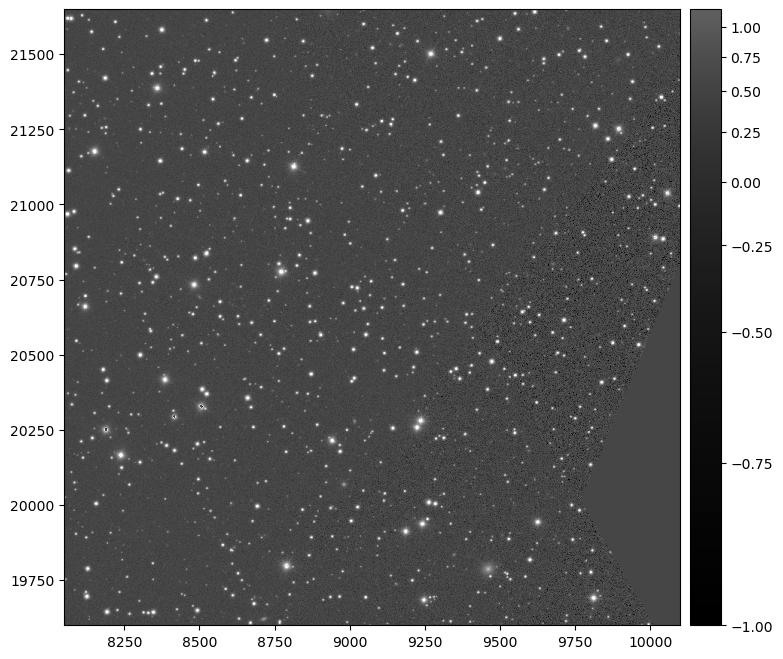

In [24]:
tract_im = butler.get('deepCoadd', dataId=match_tract_dataid)

fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(tract_im.image)
plt.gca().axis('on')
plt.show()
plt.close()

## match the bright ra and dec from truth table to diaObjectTable_tract

In [25]:
tract_gSOTable = butler.get('diaObjectTable_tract', tract=my_tract, patch=my_patch, skymap = 'ops_rehersal_prep_2k_v1')

In [26]:
trueCoords = SkyCoord(ra=bright_ra*u.degree, dec=bright_dec*u.degree)
diaCoords = SkyCoord(ra=tract_gSOTable['ra'].values*u.degree, dec=tract_gSOTable['dec'].values*u.degree)

idx, d2d, d3d = trueCoords.match_to_catalog_sky(diaCoords) #idx is closest index in diaCoords

print(idx)

152157


In [27]:
tract_gSOTable[int(idx):int(idx+1)]

,ra,dec,nDiaSources,radecMjdTai,g_psfFluxLinearSlope,g_psfFluxLinearIntercept,g_psfFluxMAD,g_psfFluxMaxSlope,g_psfFluxErrMean,g_psfFluxMean,...,i_psfFluxPercentile05,i_psfFluxPercentile25,i_psfFluxPercentile50,i_psfFluxPercentile75,i_psfFluxPercentile95,i_psfFluxSigma,i_scienceFluxSigma,i_psfFluxSkew,i_psfFluxChi2,i_psfFluxStetsonJ
diaObjectId,,,,,,,,,,,,,,,,,,,,,
792720395835801751,279.190024,-47.95352,21,60405.309117,-157940.185557,9.540678e+09,35232.835044,1.898352e+06,886.068681,366828.930023,...,123344.529618,221209.542049,242489.41381,353614.890291,821561.501531,329930.114,541183.451785,1.824282,230196.82698,163.387092


In [28]:
diaobj_id = tract_gSOTable[int(idx):int(idx+1)].index[0]

## Get flux from diaSourceTable_tract based on diaObjectId from diaObjectTable_tract

In [29]:
tract_gSDTable = butler.get('diaSourceTable_tract', tract=my_tract, patch=my_patch, skymap = 'ops_rehersal_prep_2k_v1')

In [30]:
selected_obj = tract_gSDTable[(tract_gSDTable['diaObjectId'] == diaobj_id)]

In [31]:
selected_obj

,ccdVisitId,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,dec,...,shape_flag_parent_source,ext_trailedSources_Naive_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec
diaSourceId,,,,,,,,,,,,,,,,,,,,,
3065439072148260666,730857627904,i,792720395835801751,0,0,60403.337679,43,2024-04-15 17:38:22.617177,279.190098,-47.953597,...,False,False,False,False,False,False,False,False,279.190024,-47.95352
3065439075369486877,730857628672,i,792720395835801751,0,0,60403.339118,33,2024-04-15 19:19:52.887751,279.190141,-47.953591,...,False,False,False,False,False,False,False,False,279.190024,-47.95352
3065439082885677129,730857630464,i,792720395835801751,0,0,60403.342473,32,2024-04-15 15:49:35.838741,279.190151,-47.953611,...,False,False,False,False,False,False,False,False,279.190024,-47.95352
3065439105434255431,730857635840,g,792720395835801751,0,0,60403.353901,32,2024-04-15 18:32:56.080913,279.189997,-47.953508,...,False,False,False,False,False,False,False,False,279.190024,-47.95352
3065439110802965071,730857637120,r,792720395835801751,0,0,60403.357645,46,2024-04-15 18:11:28.610243,279.190007,-47.953488,...,False,False,False,False,False,False,False,False,279.190024,-47.95352
3065439123687866494,730857640192,r,792720395835801751,0,0,60403.363400,55,2024-04-15 17:54:29.817219,279.190013,-47.953518,...,False,False,False,False,False,False,False,False,279.190024,-47.95352
3065474187800872735,730866000128,r,792720395835801751,0,0,60404.305251,34,2024-04-15 18:16:43.523956,279.190012,-47.953507,...,False,False,False,False,False,False,False,False,279.190024,-47.95352
3065474208201967839,730866004992,g,792720395835801751,0,0,60404.315705,43,2024-04-15 17:31:04.991810,279.190009,-47.953508,...,False,False,False,False,False,False,False,False,279.190024,-47.95352
3065474223234352673,730866008576,g,792720395835801751,0,0,60404.322423,33,2024-04-15 18:46:12.342033,279.190010,-47.953510,...,False,False,False,False,False,False,False,False,279.190024,-47.95352


In [32]:
# selected_obj.columns.to_list()

## Plot the light curve

In [33]:
# mjd = selected_obj['midpointMjdTai']
# flux = selected_obj['scienceFlux']
df_g = selected_obj.loc[selected_obj['band'] == 'g', ['midpointMjdTai', 'scienceFlux', 'scienceFluxErr', 'psfFlux', 'psfFluxErr']]
df_r = selected_obj.loc[selected_obj['band'] == 'r', ['midpointMjdTai', 'scienceFlux', 'scienceFluxErr', 'psfFlux', 'psfFluxErr']]
df_i = selected_obj.loc[selected_obj['band'] == 'i', ['midpointMjdTai', 'scienceFlux', 'scienceFluxErr', 'psfFlux', 'psfFluxErr']]

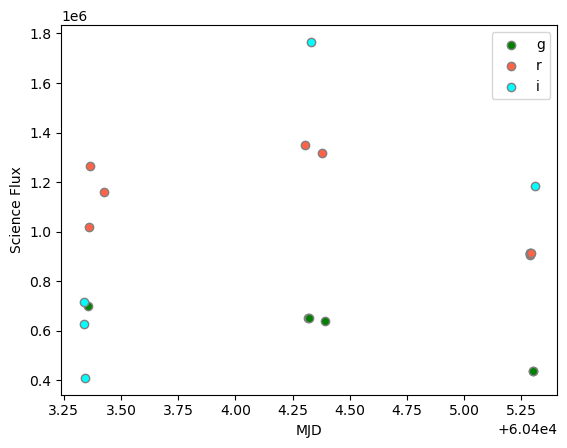

In [34]:
plt.scatter(df_g['midpointMjdTai'], df_g['scienceFlux'], edgecolor = 'grey', color='g', label='g')
plt.scatter(df_r['midpointMjdTai'], df_r['scienceFlux'], edgecolor = 'grey', color='tomato', label='r')
plt.scatter(df_i['midpointMjdTai'], df_i['scienceFlux'], edgecolor = 'grey', color='cyan', label='i')
plt.xlabel('MJD')
plt.ylabel('Science Flux')
plt.legend()

## Calculate the true light curve flux

In [35]:
mjd0 = 60400

In [36]:
# covert nJy flux to mag
g_mag = (df_g['scienceFlux'].to_numpy()*u.nJy).to(u.ABmag).value
r_mag = (df_r['scienceFlux'].to_numpy()*u.nJy).to(u.ABmag).value
i_mag = (df_i['scienceFlux'].to_numpy()*u.nJy).to(u.ABmag).value

In [37]:
# calculate the error in mag
g_mag_err = 1.09*df_g['scienceFluxErr'].to_numpy()/df_g['scienceFlux'].to_numpy()
r_mag_err = 1.09*df_r['scienceFluxErr'].to_numpy()/df_r['scienceFlux'].to_numpy()
i_mag_err = 1.09*df_i['scienceFluxErr'].to_numpy()/df_i['scienceFlux'].to_numpy()

In [38]:
# calculate the true flux based on the equation

truth_magnitude_g = np.array([bright_magnorm + bright_magamp*np.sin(2.*np.pi*(mjd - mjd0)/bright_period + bright_phase) for mjd in df_g['midpointMjdTai'].to_numpy()])
truth_magnitude_r = np.array([bright_magnorm + bright_magamp*np.sin(2.*np.pi*(mjd - mjd0)/bright_period + bright_phase) for mjd in df_r['midpointMjdTai'].to_numpy()])
truth_magnitude_i = np.array([bright_magnorm + bright_magamp*np.sin(2.*np.pi*(mjd - mjd0)/bright_period + bright_phase) for mjd in df_i['midpointMjdTai'].to_numpy()])

## Compare the true flux with the pipeline flux

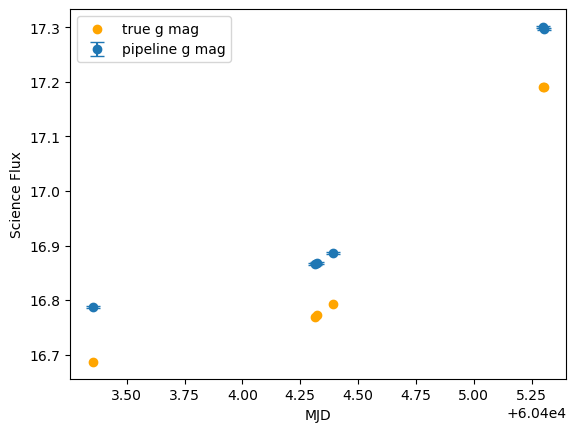

In [39]:
plt.errorbar(df_g['midpointMjdTai'].to_numpy(), g_mag, yerr=g_mag_err, fmt='o', capsize=5, label='pipeline g mag')
plt.scatter(df_g['midpointMjdTai'].to_numpy(), truth_magnitude_g, color='orange', label='true g mag')
plt.xlabel('MJD')
plt.ylabel('Science Flux')
plt.legend()

Text(0, 0.5, 'pipeline - true')

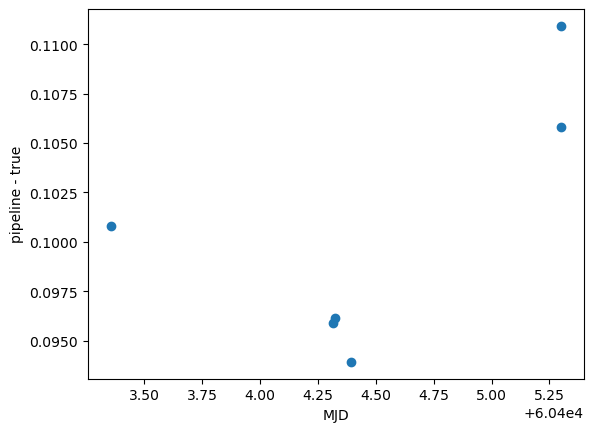

In [40]:
# find the difference between true and pipeline flux
g_diff = (g_mag - truth_magnitude_g)
plt.scatter(df_g['midpointMjdTai'].to_numpy(), g_diff)
plt.xlabel('MJD')
plt.ylabel('pipeline - true')

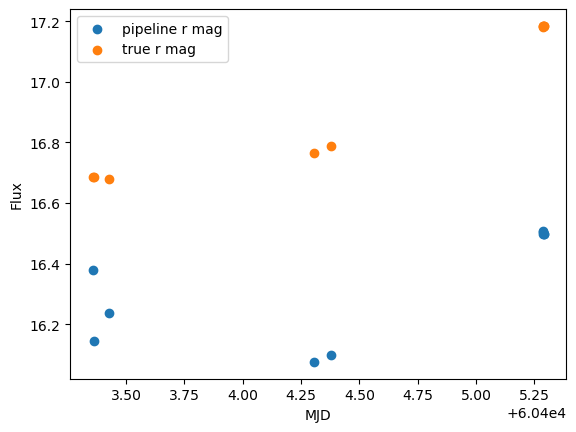

In [41]:
plt.scatter(df_r['midpointMjdTai'].to_numpy(), r_mag, label='pipeline r mag')
plt.scatter(df_r['midpointMjdTai'].to_numpy(), truth_magnitude_r, label='true r mag')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.legend()

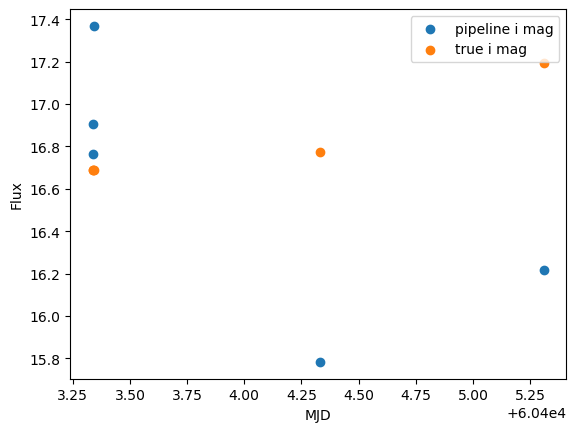

In [42]:
plt.scatter(df_i['midpointMjdTai'].to_numpy(), i_mag, label='pipeline i mag')
plt.scatter(df_i['midpointMjdTai'].to_numpy(), truth_magnitude_i, label='true i mag')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.legend()